<a href="https://colab.research.google.com/github/brainopensource/datascience-mvp/blob/ml-analytics-mvp/MVP_Machine_Learning_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MVP de Machine Learning & Analytics para conclusão da Sprint da Pós-Graduação em Ciência de Dados e Analytics (PUC Rio)

Aluno: Lucas da S. Rocha

# Introdução

Este notebook apresenta o desenvolvimento de um Mínimo Produto Viável (MVP) como parte do segundo módulo da Pós-Graduação em Ciência de Dados e Analytics da PUC-Rio. Utilizando dados abertos recentes sobre a produção de petróleo e gás no Brasil, disponibilizados pela Agência Nacional de Petróleo (ANP).

# Código do MVP

## Importação de Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import hashlib
import warnings
import missingno as msno
import re

## Configuração do Ambiente

Configurações estéticas do pandas para limitar o máximo de linhas, colunas e filtrar avisos.

In [55]:
# Definindo o limite de exibição colunas de dataframe para None (sem limite)
pd.set_option('display.max_columns', 30)

# Definindo o limite de exibição de linhas de dataframe para 48
pd.set_option('display.max_rows', 145)

# Filter warnings
warnings.filterwarnings('ignore')

## Variáveis Globais

In [ ]:
# Data de referência da última produção presente no dado
data_referencia = pd.to_datetime('2024-06-01')

## Funções Auxiliares

In [15]:
def calc_tempo_produzindo(df):
  """
    Calcula o tempo total de produção em meses para cada registro no DataFrame,
    com base no período mínimo de produção registrado por campo.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo informações de produção, incluindo as colunas:
        - 'campo' (identificação do campo de produção)
        - 'periodo' (data do registro de produção, no formato datetime)

    Retorno:
    --------
    pandas.DataFrame
        O DataFrame original com duas novas colunas:
        - 'data_inicio': Data mínima de início de produção por campo.
        - 'tempo_total_producao_meses': Tempo total de produção em meses
          calculado para cada registro desde o início.
    # Encontrar a data mínima de produção por campo
    min_dates = df.groupby('campo')['periodo'].transform('min')  # Transform para alinhar ao DataFrame original
    """

  # Encontrar a data mínima de produção por campo
  min_dates = df.groupby('campo')['periodo'].transform('min')  # Transform para alinhar ao DataFrame original

  # Adicionar a data mínima ao DataFrame original
  df['data_inicio'] = min_dates

  # Calcular o tempo total de produção em meses para cada registro
  df['tempo_total_producao_meses'] = ((df['periodo'].dt.year - df['data_inicio'].dt.year) * 12 +
                                        (df['periodo'].dt.month - df['data_inicio'].dt.month))

  return df

## Criando dataframe
Os datasets obtidos de dados abertos da ANP foram compilados num arquivo de formato 'parquet'. Ele contem dados de 1980 até 2024 com as produções por poços em campos offshore na costa Brasileira.

Foram usadas técnicas de pré-processamento do módulo lecionado no trimestre anterior, fazendo uso dos conceitos apresentados para preparar o dataset pra ser utilizado posteriormente.

Conforme sugerido, os dados foram disponibilizados publicamente no repositório do Github e lidos no formato Raw.

[Link do Repositório](https://github.com/brainopensource/datascience-mvp)

[Fonte de Informação de dados abertos](https://cdp.anp.gov.br/ords/r/cdp_apex/consulta-dados-publicos-cdp/consulta-produ%C3%A7%C3%A3o-por-po%C3%A7o)

In [ ]:
url = "https://raw.githubusercontent.com/brainopensource/datascience-mvp/refs/heads/ml-analytics-mvp/datasets/monthly_production_concat/1980_2024_BR_production_data.parquet"

df_prod_base = pd.read_parquet(url).reset_index(drop=True)

# Exibindo um subset com os dados referente ao campo TUPI e seus tipos de dados por coluna
display(df_prod_base[df_prod_base['campo'] == 'TUPI'].head(5))

print(df_prod_base.dtypes)

,estado,bacia,nome_poco_anp,campo,periodo,oleo_kbd,condensado_kbd,petroleo_kbd,gas_natural_mmscf_assoc,gas_natural_mmscf_nassoc,gas_natural_mmscf_total,agua_kbd,tempo_producao_hspormes,ano,mes
14,Rio de Janeiro,Santos,9-BRSA-716-RJS,TUPI,2011-01-01,13.188175,0.0,13.188175,21.049140,0.0,21.049140,0.0,0,2011,1
30,Rio de Janeiro,Santos,9-BRSA-716-RJS,TUPI,2011-02-01,14.871802,0.0,14.871802,24.602713,0.0,24.602713,0.0,0,2011,2
37,Rio de Janeiro,Santos,9-BRSA-716-RJS,TUPI,2011-03-01,14.601435,0.0,14.601435,24.307998,0.0,24.307998,0.0,0,2011,3
54,Rio de Janeiro,Santos,9-BRSA-716-RJS,TUPI,2011-04-01,21.318976,0.0,21.318976,36.219512,0.0,36.219512,0.0,0,2011,4
72,Rio de Janeiro,Santos,9-BRSA-716-RJS,TUPI,2011-05-01,28.436432,0.0,28.436432,44.274315,0.0,44.274315,0.0,0,2011,5


estado                              object
bacia                               object
nome_poco_anp                       object
campo                               object
periodo                     datetime64[ns]
oleo_kbd                           float64
condensado_kbd                     float64
petroleo_kbd                       float64
gas_natural_mmscf_assoc            float64
gas_natural_mmscf_nassoc           float64
gas_natural_mmscf_total            float64
agua_kbd                           float64
tempo_producao_hspormes              int64
ano                                  int32
mes                                  int32
dtype: object


In [112]:
# Criando uma cópia do dataframe e listando todos os campos presentes no registro
df_prod = df_prod_base.copy(deep=True)
campos = df_prod['campo'].unique()
print(campos)

['PAMPO' 'CARATINGA' 'TRILHA' 'SAPINHOÁ' 'BADEJO' 'BARRACUDA' 'JUBARTE'
 'LINGUADO' 'TUPI' 'MARLIM LESTE' 'VOADOR' 'MARLIM' 'LAPA' 'BALEIA AZUL'
 'PIRAMBU' 'BÚZIOS' 'PEO-1BRSA1146RJS_Iara_Entorno_CCO' 'BALEIA FRANCA'
 'SÉPIA' 'BERBIGÃO' 'ATAPU' 'OESTE DE ATAPU' 'ITAPU' 'SURURU' 'MERO'
 'NORDESTE DE SAPINHOÁ' 'NOROESTE DE SAPINHOÁ' 'SUDOESTE DE SAPINHOÁ'
 'SUL DE TUPI' 'AnC_TUPI' 'TAMBUATÁ' 'AnC_BRAVA' 'ALBACORA'
 'AnC_NORTE_ATAPU' 'SÉPIA LESTE' 'BÚZIOS_ECO' 'AnC_MERO' 'SUL DE BERBIGÃO'
 'SÉPIA_ECO' 'ATAPU_ECO' 'MARLIM SUL' 'ITAPU_ECO' 'AnC_Forno' 'ESPADIM'
 'GUARICEMA' 'DOURADO' 'BONITO' 'ENCHOVA' 'GAROUPA' 'NAMORADO' 'CAÇÃO'
 'AGULHA' 'UBARANA' 'CAIOBA' 'CAMORIM' 'DOM JOÃO MAR' 'CANDEIAS'
 'AREA DO SES-2' 'ROBALO' 'AREA do BAS-37 (Licitado)' 'CURIMÃ'
 'GAROUPINHA' 'XARÉU' 'BICUDO' 'DOM JOÃO' 'TATUI' 'AREA DO RNS-36'
 'ESPADA' 'ITAPARICA' 'PARATI' 'CORVINA' 'ATUM' 'CHERNE' 'PIRAÚNA' 'BAGRE'
 'ÁREA DO RJS-150' 'ENCHOVA OESTE' 'ANEQUIM' 'VIOLA' 'MARIMBÁ' 'MORÉIA'
 'SALGO' 'ARATUM' 'NORDE

## Transformações de dado

Nesse MVP iremos trabalhar com as produções por campo, agregando as produções de petróleo, água, gás e condensados por campo e por período mensal, pois é a granularidade da nossa base de dados.

In [113]:
# Converte a coluna 'periodo' para o formato datetime, tratando valores inválidos como NaT (Not a Time)
df_prod['periodo'] = pd.to_datetime(df_prod['periodo'], errors='coerce')

# Criando um mapeamento único de campo -> bacia
bacia_por_campo = df_prod[['campo', 'bacia']].drop_duplicates().set_index('campo')

# Agrupamento dos dados por campo
df_fields_prod = df_prod.groupby(['campo', 'periodo']).agg(
    oleo_kbd_total=('oleo_kbd', 'sum'),
    condensado_kbd_total=('condensado_kbd', 'sum'),
    petroleo_kbd_total=('petroleo_kbd', 'sum'),
    gas_natural_mmscf_assoc_total=('gas_natural_mmscf_assoc', 'sum'),
    gas_natural_mmscf_nassoc_total=('gas_natural_mmscf_nassoc', 'sum'),
    gas_natural_mmscf_total_total=('gas_natural_mmscf_total', 'sum'),
    agua_kbd_total=('agua_kbd', 'sum'),
    tempo_producao_hspormes_total=('tempo_producao_hspormes', 'sum')
).reset_index()

# Adicionar a coluna 'bacia' ao resultado final a partir do mapeamento
df_fields_prod['bacia'] = df_fields_prod['campo'].map(bacia_por_campo['bacia'])

# Exibir o DataFrame auxiliar
display(df_fields_prod.head(2))

,campo,periodo,oleo_kbd_total,condensado_kbd_total,petroleo_kbd_total,gas_natural_mmscf_assoc_total,gas_natural_mmscf_nassoc_total,gas_natural_mmscf_total_total,agua_kbd_total,tempo_producao_hspormes_total,bacia
0,ABALONE,2009-07-01,1.019355,0.0,1.019355,3.605638,0.0,3.605638,0.0,292,Campos
1,ABALONE,2009-08-01,0.670778,0.0,0.670778,2.061891,0.0,2.061891,0.0,178,Campos


In [114]:
# Selecionar apenas os campos da Bacia de Santos numa lista
campos_santos = (bacia_por_campo[bacia_por_campo.bacia == 'Santos']).index.tolist()
print(campos_santos)

['SAPINHOÁ', 'TUPI', 'LAPA', 'BÚZIOS', 'PEO-1BRSA1146RJS_Iara_Entorno_CCO', 'SÉPIA', 'BERBIGÃO', 'ATAPU', 'OESTE DE ATAPU', 'ITAPU', 'SURURU', 'MERO', 'NORDESTE DE SAPINHOÁ', 'NOROESTE DE SAPINHOÁ', 'SUDOESTE DE SAPINHOÁ', 'SUL DE TUPI', 'AnC_TUPI', 'TAMBUATÁ', 'AnC_NORTE_ATAPU', 'SÉPIA LESTE', 'BÚZIOS_ECO', 'AnC_MERO', 'SUL DE BERBIGÃO', 'SÉPIA_ECO', 'ATAPU_ECO', 'ITAPU_ECO', 'CORAL', 'MERLUZA', 'CARAVELA', 'CAVALO-MARINHO', 'ESTRELA DO MAR', 'LAGOSTA', 'BAÚNA', 'URUGUÁ', 'MEXILHÃO', 'PIRACABA', 'TAMBAÚ', 'ATLANTA']


In [115]:
# Calcular o número de dias em cada mês do período
df_fields_prod['dias_no_mes'] = df_fields_prod['periodo'].dt.days_in_month

# Calcular a produção total do mês em barris (KBD * dias_no_mes)
df_fields_prod['oleo_kb_total_mes'] = df_fields_prod['oleo_kbd_total'] * df_fields_prod['dias_no_mes']

# Calcular a produção acumulada campo
df_fields_prod['producao_acumulada'] = df_fields_prod.groupby('campo')['oleo_kb_total_mes'].cumsum()

# Ordenar o dado por período e por campo
df_fields_prod.sort_values(by=['periodo', 'campo'], inplace=True)

In [116]:
# Aplicar a função ao DataFrame e calcular o tempo total de produção do campo que sinaliza a maturidade do campo
df_fields_prod = calc_tempo_produzindo(df_fields_prod)

In [117]:
# Exibir algumas linhas para verificar as novas colunas
display(df_fields_prod.head(5))
display(df_fields_prod.tail(5))

,campo,periodo,oleo_kbd_total,condensado_kbd_total,petroleo_kbd_total,gas_natural_mmscf_assoc_total,gas_natural_mmscf_nassoc_total,gas_natural_mmscf_total_total,agua_kbd_total,tempo_producao_hspormes_total,bacia,dias_no_mes,oleo_kb_total_mes,producao_acumulada,data_inicio,tempo_total_producao_meses
180,AGULHA,1980-01-01,5.687206,0.0,5.687206,3.063783,0.0,3.063783,0.113075,0,Potiguar,31,176.303374,176.303374,1980-01-01,0
2512,AREA DO SES-2,1980-01-01,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0,Sergipe,31,0.000000,0.000000,1980-01-01,0
6156,BONITO,1980-01-01,3.853138,0.0,3.853138,1.852973,0.0,1.852973,0.000000,0,Campos,31,119.447266,119.447266,1980-01-01,0
6953,CAIOBA,1980-01-01,8.026630,0.0,8.026630,21.512356,0.0,21.512356,1.122630,0,Sergipe,31,248.825518,248.825518,1980-01-01,0
7709,CAMORIM,1980-01-01,3.093186,0.0,3.093186,9.161707,0.0,9.161707,0.011667,0,Sergipe,31,95.888781,95.888781,1980-01-01,0


,campo,periodo,oleo_kbd_total,condensado_kbd_total,petroleo_kbd_total,gas_natural_mmscf_assoc_total,gas_natural_mmscf_nassoc_total,gas_natural_mmscf_total_total,agua_kbd_total,tempo_producao_hspormes_total,bacia,dias_no_mes,oleo_kb_total_mes,producao_acumulada,data_inicio,tempo_total_producao_meses
29626,TUBARÃO MARTELO,2024-06-01,7.491990,0.000000,7.491990,0.708060,0.000000,0.708060,4.116145,3397,Campos,30,224.759712,3.227508e+04,2013-12-01,126
29808,TUPI,2024-06-01,787.079691,0.000000,787.079691,1402.080312,0.000000,1402.080312,119.784603,34368,Santos,30,23612.390733,2.822499e+06,2009-04-01,182
30481,URUGUÁ,2024-06-01,2.185382,0.028356,2.213738,1.966330,1.082456,3.048785,2.742418,1486,Santos,30,65.561472,4.022173e+04,2010-07-01,167
30904,VERMELHO,2024-06-01,6.829628,0.000000,6.829628,0.881699,0.000000,0.881699,75.755939,10872,Campos,30,204.888846,1.734700e+05,1989-01-01,425
31643,VOADOR,2024-06-01,5.288838,0.000000,5.288838,5.505039,0.000000,5.505039,0.029656,923,Campos,30,158.665137,8.341508e+04,1992-11-01,379


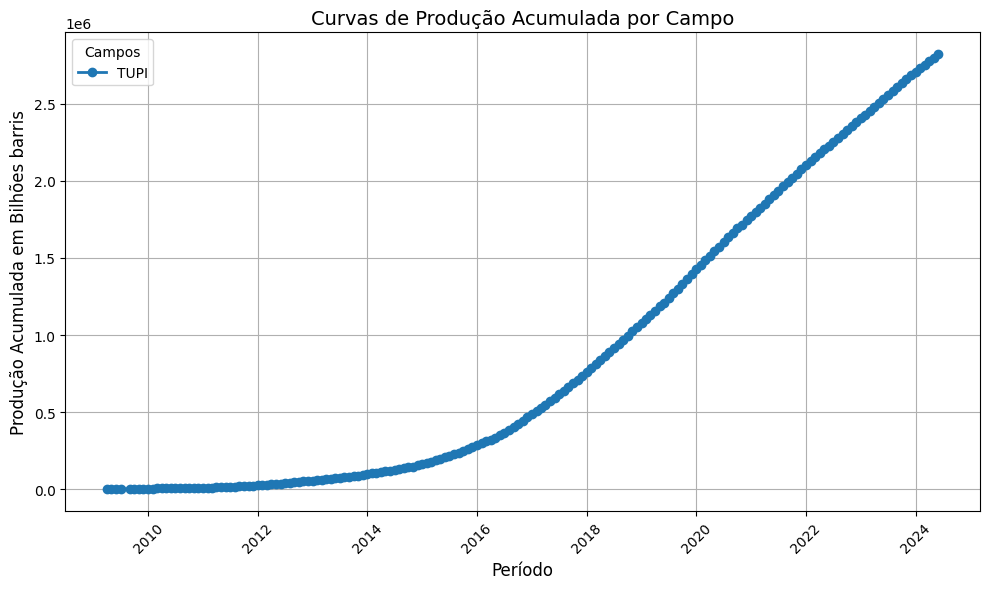

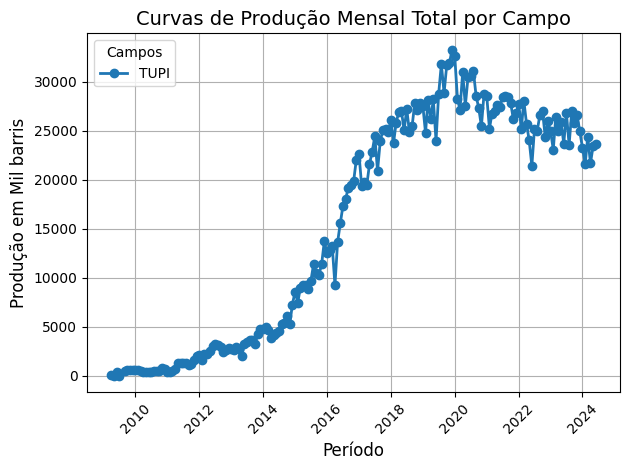

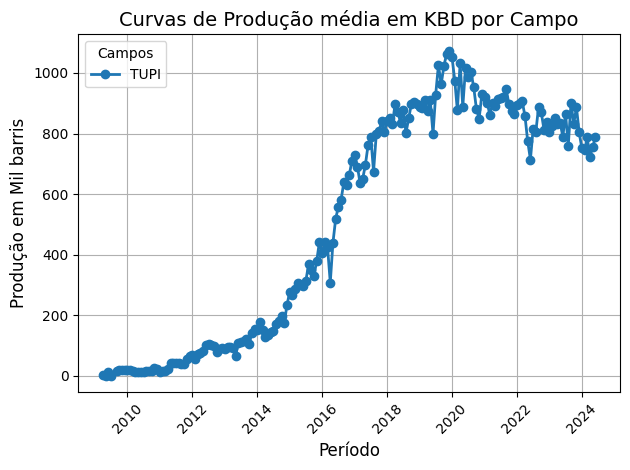

In [118]:
# Criar um gráfico de produção acumulada para TUPI
plt.figure(figsize=(10, 6))

# Plotar a produção acumulada
for campo in ['TUPI']:
    df_campo = df_fields_prod[df_fields_prod['campo'] == campo]
    plt.plot(df_campo['periodo'], df_campo['producao_acumulada'], label=campo, linestyle='-', marker='o', linewidth=2)

    # Adicionar título, rótulos e legenda
    plt.title('Curvas de Produção Acumulada por Campo', fontsize=14)
    plt.xlabel('Período', fontsize=12)
    plt.ylabel('Produção Acumulada em Bilhões barris', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Campos', loc='upper left')

    # Exibir o gráfico
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plotar a produção total mensal
for campo in ['TUPI']:
    df_campo = df_fields_prod[df_fields_prod['campo'] == campo]
    plt.plot(df_campo['periodo'], df_campo['oleo_kb_total_mes'], label=campo, linestyle='-', marker='o', linewidth=2)

    # Adicionar título, rótulos e legenda
    plt.title('Curvas de Produção Mensal Total por Campo', fontsize=14)
    plt.xlabel('Período', fontsize=12)
    plt.ylabel('Produção em Mil barris', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Campos', loc='upper left')

    # Exibir o gráfico
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plotar a produção média em KBD mensalmente
for campo in ['TUPI']:
    df_campo = df_fields_prod[df_fields_prod['campo'] == campo]
    plt.plot(df_campo['periodo'], df_campo['oleo_kbd_total'], label=campo, linestyle='-', marker='o', linewidth=2)

    # Adicionar título, rótulos e legenda
    plt.title('Curvas de Produção média em KBD por Campo', fontsize=14)
    plt.xlabel('Período', fontsize=12)
    plt.ylabel('Produção em Mil barris', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Campos', loc='upper left')

    # Exibir o gráfico
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## MACHINE LEARNING

Nessa seção iremos treinar os modelos de Machine Learning usando as técnicas de Regressão Linear, Gradient Boosting,


Numa primeira versão do modelo iremos utilizar as features:
 - tempo em meses que o campo produz desde o primeiro óleo
 - produção de petróleo em mil barris
 - campo que produziu

In [119]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Treinamento de Modelos

#### 1 Linear Regression

In [182]:
from sklearn.linear_model import LinearRegression

# Selecionando as colunas relevantes para o treinamento

# A coluna producao_acumulada corresponde a produção total de petróleo em barris de cada campo em cada período e será o alvo de nosso estudo
df_fields = df_fields_prod[['campo', 'tempo_total_producao_meses', 'oleo_kbd_total']]

# Filtrando apenas para os campos da bacia de Santos
#df_fields_santos = df_fields[df_fields['campo'].isin(campos_santos)]
df_fields_santos = df_fields[df_fields['campo'].isin(campos_santos)]

In [183]:
# Criando dois encoders distintos
label_encoder_campo = LabelEncoder()

# Codificando as variáveis categóricas separadamente
df_fields_santos['campo'] = label_encoder_campo.fit_transform(df_fields_santos['campo'])

# Exibindo as classes codificadas de cada coluna
#print("Classes codificadas para 'campo':")
#print(label_encoder_campo.classes_)
# Supondo que label_encoder_campo seja o seu LabelEncoder já treinado
campo_classes_dict = {index: label for index, label in enumerate(label_encoder_campo.classes_)}

# Exibindo o dicionário
print("Dicionário de classes codificadas para 'campo':")
print(campo_classes_dict)

Dicionário de classes codificadas para 'campo':
{0: 'ATAPU', 1: 'ATAPU_ECO', 2: 'ATLANTA', 3: 'AnC_MERO', 4: 'AnC_NORTE_ATAPU', 5: 'AnC_TUPI', 6: 'BAÚNA', 7: 'BERBIGÃO', 8: 'BÚZIOS', 9: 'BÚZIOS_ECO', 10: 'CARAVELA', 11: 'CAVALO-MARINHO', 12: 'CORAL', 13: 'ESTRELA DO MAR', 14: 'ITAPU', 15: 'ITAPU_ECO', 16: 'LAGOSTA', 17: 'LAPA', 18: 'MERLUZA', 19: 'MERO', 20: 'MEXILHÃO', 21: 'NORDESTE DE SAPINHOÁ', 22: 'NOROESTE DE SAPINHOÁ', 23: 'OESTE DE ATAPU', 24: 'PEO-1BRSA1146RJS_Iara_Entorno_CCO', 25: 'PIRACABA', 26: 'SAPINHOÁ', 27: 'SUDOESTE DE SAPINHOÁ', 28: 'SUL DE BERBIGÃO', 29: 'SUL DE TUPI', 30: 'SURURU', 31: 'SÉPIA', 32: 'SÉPIA LESTE', 33: 'SÉPIA_ECO', 34: 'TAMBAÚ', 35: 'TAMBUATÁ', 36: 'TUPI', 37: 'URUGUÁ'}


In [185]:
# Ordenando o dado por tempo de produção para ser feito o split de treino com dados históricos e de teste com dados recentes
df_fields_santos = df_fields_santos.sort_values(by='tempo_total_producao_meses')

In [186]:
# Ordenando o DataFrame original
df_fields_santos = df_fields_santos.sort_values(by=['campo', 'tempo_total_producao_meses'])

# Preenchendo os gaps antes de aplicar o agrupamento
final_data = []

# Para cada campo, vamos preencher os períodos faltantes
for campo, group in df_fields_santos.groupby('campo'):
    # Criar a sequência completa de meses (do menor ao maior mês)
    all_months = np.arange(group['tempo_total_producao_meses'].min(), group['tempo_total_producao_meses'].max() + 1)

    # Criar um DataFrame com todos os meses e preencher o 'oleo_kbd_total' com 0 para meses ausentes
    full_group = pd.DataFrame({
        'tempo_total_producao_meses': all_months
    })

    # Juntar com os dados originais para preencher os valores de produção
    full_group = full_group.merge(group[['tempo_total_producao_meses', 'oleo_kbd_total']],
                                  on='tempo_total_producao_meses', how='left')

    # Preencher os valores ausentes com 0
    full_group['oleo_kbd_total'] = full_group['oleo_kbd_total'].fillna(0)

    # Adiciona o campo ao final dos dados
    full_group['campo'] = campo

    # Adicionando ao resultado final
    final_data.append(full_group)

# Concatenar todos os campos em um único DataFrame
df_fields_santos_filled = pd.concat(final_data).sort_values(by=['campo', 'tempo_total_producao_meses'])

# Remover campos onde a produção total é maior do que 1 milhão de barris
df_fields_santos_filled = df_fields_santos_filled.groupby('campo').filter(lambda x: x['oleo_kbd_total'].sum() > 100)

In [187]:
# Lista para armazenar os dados de treino e teste
train_data = []
test_data = []

# Para cada campo, separamos os dados em treino e teste
for campo, group in df_fields_santos_filled.groupby('campo'):
    # Garantir que o grupo está ordenado por tempo_total_producao_meses
    group_sorted = group.sort_values(by='tempo_total_producao_meses')

    # Definindo a separação 80% treino e 20% teste
    train_size = int(len(group_sorted) * 0.8)

    # Dividindo os dados do campo
    train_data.append(group_sorted.iloc[:train_size])
    test_data.append(group_sorted.iloc[train_size:])

    # Plotando os dados para cada campo - COMENTADO PRA PERFORMANCE
    #plt.figure(figsize=(10, 6))
    #plt.plot(group_sorted['tempo_total_producao_meses'][:train_size], group_sorted['oleo_kbd_total'][:train_size], label='Treinamento', color='blue')
    #plt.plot(group_sorted['tempo_total_producao_meses'][train_size:], group_sorted['oleo_kbd_total'][train_size:], label='Teste', color='red')

    #plt.title(f'Campo: {campo} - Produção de Óleo (Treinamento vs Teste)')
    #plt.xlabel('Meses de Produção')
    #plt.ylabel('Produção de Óleo (KBD)')
    #plt.legend()
    #plt.grid(True)
    #plt.show()

In [188]:
# Concatenando os dados de treino e teste
df_train = pd.concat(train_data).sort_index()
df_test = pd.concat(test_data).sort_index()

# Verificando as dimensões dos datasets de treino e teste
print("Dimensões do conjunto de treino:", df_train.shape)
print("Dimensões do conjunto de teste:", df_test.shape)

# Separando as colunas de features e target para treino
X_train = df_train.drop(columns=['oleo_kbd_total'])  # Features do conjunto de treino
y_train = df_train['oleo_kbd_total']  # Target do conjunto de treino

# Separando as colunas de features e target para teste
X_test = df_test.drop(columns=['oleo_kbd_total'])  # Features do conjunto de teste
y_test = df_test['oleo_kbd_total']  # Target do conjunto de teste

Dimensões do conjunto de treino: (2088, 3)
Dimensões do conjunto de teste: (536, 3)
Dimensões de X_train: (2088, 2)
Dimensões de X_test: (536, 2)
Dimensões de y_train: (2088,)
Dimensões de y_test: (536,)


In [189]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R2: {r2}')

MAE: 151.1356357931734
MSE: 41774.90970258589
R2: 0.07640628540957195


##### Previsão

In [224]:
# Campos na Bacia de Santos
# SAPINHOÁ', 'TUPI', 'LAPA', 'BÚZIOS', 'SÉPIA', 'BERBIGÃO', 'ATAPU', 'OESTE DE ATAPU',
#'ITAPU', 'SURURU', 'MERO', 'NORDESTE DE SAPINHOÁ', 'NOROESTE DE SAPINHOÁ',
#'SUDOESTE DE SAPINHOÁ', 'SUL DE TUPI', 'AnC_TUPI', 'TAMBUATÁ', 'AnC_NORTE_ATAPU',
#'SÉPIA LESTE', 'BÚZIOS_ECO', 'AnC_MERO', 'SUL DE BERBIGÃO', 'SÉPIA_ECO', 'ATAPU_ECO',
#'ITAPU_ECO', 'CORAL', 'MERLUZA', 'CARAVELA', 'CAVALO-MARINHO', 'ESTRELA DO MAR',
#'LAGOSTA', 'BAÚNA', 'URUGUÁ', 'MEXILHÃO', 'PIRACABA', 'TAMBAÚ', 'ATLANTA'

# Procurar o índice do valor 'TUPI'
campo = 'MERO'
indice = int(list(label_encoder_campo.classes_).index(campo))
print(f"O índice de {campo} na lista é: {indice}")

# Filtrando o DataFrame para o campo específico
df_campo = df_fields_santos_filled[df_fields_santos_filled['campo'] == indice]

# Encontrando o período máximo para esse campo
periodo_maximo = df_campo['tempo_total_producao_meses'].max()
print(f"O período máximo para o campo {campo} é: {periodo_maximo}")

O índice de MERO na lista é: 19
O período máximo para o campo MERO é: 80


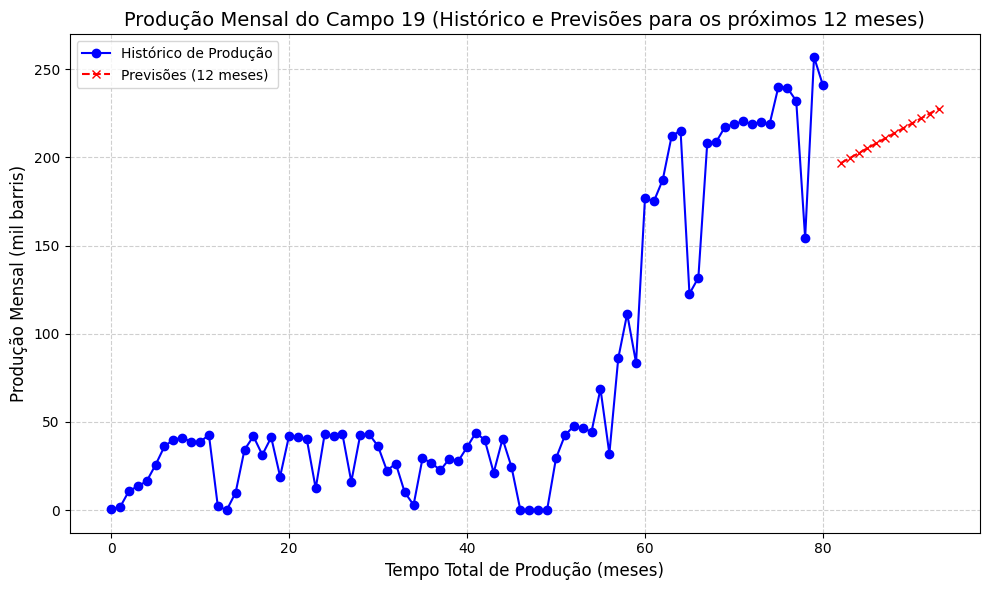

In [225]:
# Definindo o campo e o tempo inicial (último mês registrado + 1)
campo_encoded = indice  # Código do campo
tempo_total_producao_meses = periodo_maximo + 1
num_meses_futuro = 12*1  # Número de meses para prever

# Preparar os dados de entrada para a previsão
X_novo = np.array([[campo_encoded, tempo_total_producao_meses]])

# Lista para armazenar previsões
previsoes_futuro = []

# Realizar previsões para os próximos 24 meses
for mes in range(1, num_meses_futuro + 1):
    # Atualizar o tempo total de produção
    X_novo[0][1] = tempo_total_producao_meses + mes

    # Fazer a previsão para o próximo mês
    y_pred_futuro = model.predict(X_novo)

    # Armazenar a previsão
    previsoes_futuro.append([tempo_total_producao_meses + mes, y_pred_futuro[0]])

# Convertendo a lista de previsões em DataFrame
df_futuro = pd.DataFrame(previsoes_futuro, columns=['tempo_total_producao_meses', 'oleo_kbd_total'])

# Selecionando apenas TUPI para exibir o histórico
df_campo_historico = df_fields_santos_filled[df_fields_santos_filled['campo'] == campo_encoded][['tempo_total_producao_meses', 'oleo_kbd_total']]

# Concatenando dados históricos e previsões
df_historico_e_projetado = pd.concat([df_campo_historico, df_futuro], ignore_index=True)

# Criando o gráfico
plt.figure(figsize=(10, 6))

# Plotando os dados históricos
plt.plot(df_campo_historico['tempo_total_producao_meses'], df_campo_historico['oleo_kbd_total'], label='Histórico de Produção', color='blue', marker='o')

# Plotando as previsões para os próximos 24 meses
plt.plot(df_futuro['tempo_total_producao_meses'], df_futuro['oleo_kbd_total'], label=f'Previsões ({num_meses_futuro} meses)', color='red', marker='x', linestyle='--')

# Customizando o gráfico
plt.title(f'Produção Mensal do Campo {campo_encoded} (Histórico e Previsões para os próximos {num_meses_futuro} meses)', fontsize=14)
plt.xlabel('Tempo Total de Produção (meses)', fontsize=12)
plt.ylabel('Produção Mensal (mil barris)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

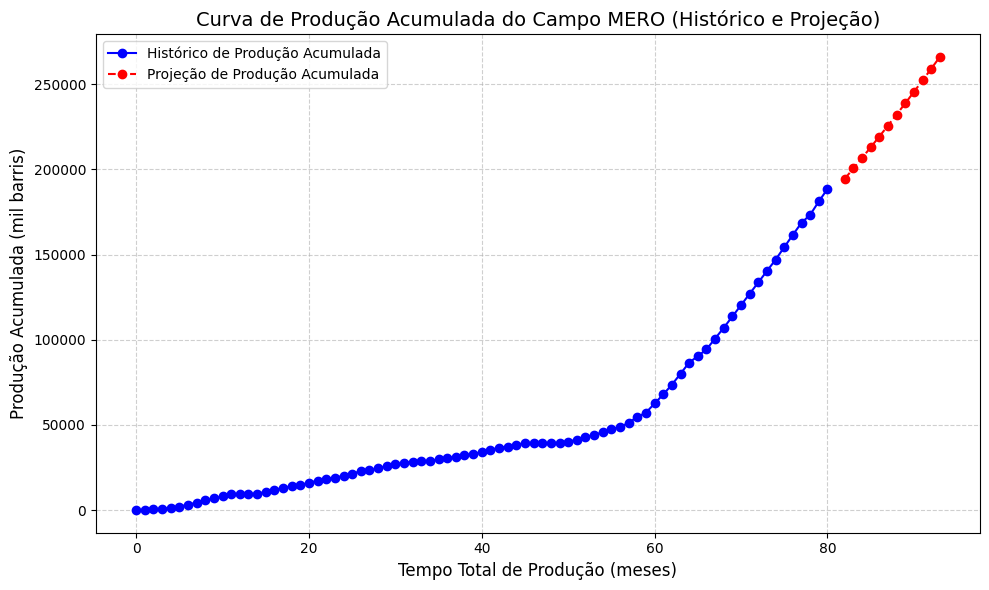

In [226]:
# Calcular a produção acumulada histórica
df_historico_e_projetado['producao_acumulada'] = df_historico_e_projetado['oleo_kbd_total'] * 30.42 # Arredondando o numero de dias no mes para simplificar
df_historico_e_projetado['producao_acumulada'] = df_historico_e_projetado['producao_acumulada'].cumsum()

# Separar histórico e projeção
df_historico = df_historico_e_projetado[df_historico_e_projetado['tempo_total_producao_meses'] <= periodo_maximo]
df_projetado = df_historico_e_projetado[df_historico_e_projetado['tempo_total_producao_meses'] > periodo_maximo]

# Criar o gráfico
plt.figure(figsize=(10, 6))

# Plotando a curva acumulada histórica (linha azul)
plt.plot(df_historico['tempo_total_producao_meses'], df_historico['producao_acumulada'], label='Histórico de Produção Acumulada', color='blue', marker='o')

# Plotando a curva acumulada projetada (linha vermelha)
plt.plot(df_projetado['tempo_total_producao_meses'], df_projetado['producao_acumulada'], label='Projeção de Produção Acumulada', color='red', linestyle='--', marker='o')

# Adicionando título e rótulos aos eixos
plt.title(f'Curva de Produção Acumulada do Campo {campo} (Histórico e Projeção)', fontsize=14)
plt.xlabel('Tempo Total de Produção (meses)', fontsize=12)
plt.ylabel('Produção Acumulada (mil barris)', fontsize=12)

# Adicionando legenda
plt.legend()

# Adicionando grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ajustando o layout
plt.tight_layout()

# Exibindo o gráfico
plt.show()

#### 2 Gradient Boosting

In [231]:
from sklearn.ensemble import GradientBoostingRegressor

# Selecionando as colunas relevantes
df_fields = df_fields_prod[['campo', 'tempo_total_producao_meses', 'oleo_kbd_total']]

df_fields = df_fields.sort_values(by='tempo_total_producao_meses')

# Codificando a variável 'campo'
campo_encoder = LabelEncoder()
df_fields['campo'] = campo_encoder.fit_transform(df_fields['campo'])

display(df_fields.campo.unique())

array([  1,  14,  23,  17,  94, 120,  11,  12, 125,  93,  54,  72,  95,
        51,  28, 123,  69, 104, 111, 109,  50,  34, 124,  92,  91,  18,
         3, 114,  19, 105,  22,  13, 133,  83,  86,  63, 122,  78,   5,
        56, 142, 110, 102, 135,  68,  98, 130,  75, 136,  37,  42,  29,
       103,  87,  77,   0,  96,  21,  64, 117,  25,  10,  38,  40,  27,
        57, 119,  66,  76,  73,  33,  16,  80,  99, 107, 129,  97, 112,
        71,  62, 108,  24, 126, 132,   7,  31, 106, 134,  35, 144,  74,
       138, 101,  88, 116,  55,  47,   4, 140,  85, 143,  15,   6,   2,
        90, 128, 137,  48,  43, 100,  81,  84, 115, 139,  45,  30,  79,
         9, 141,  52,  82,  53, 127, 113,  65, 121,  26,  36,  39,  89,
        46,  41,  49,  58,   8,  44, 118,  32,  61,  70,  67,  60,  20,
        59, 131])

In [ ]:
# Determinar o ponto de corte para treino e teste (80% para treino, 20% para teste, por exemplo)
split_index = int(len(df_fields) * 0.9)

# Separar dados de treino e teste
X_train = df_fields.iloc[:split_index][['campo', 'tempo_total_producao_meses']]
y_train = df_fields.iloc[:split_index]['oleo_kb_total']

X_test = df_fields.iloc[split_index:][['campo', 'tempo_total_producao_meses']]
y_test = df_fields.iloc[split_index:]['oleo_kb_total']

# Verificar as divisões
print(f'Tamanho do conjunto de treino: {len(X_train)}')
print(f'Tamanho do conjunto de teste: {len(X_test)}')

Tamanho do conjunto de treino: 28942
Tamanho do conjunto de teste: 3216


In [ ]:
# Treinar o modelo novamente com os dados ordenados
#model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Avaliar no conjunto de teste
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')

"""
#model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
MAE: 104.38263490491147
MSE: 59345.95482076363
R²: -2.33028153677898


model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=3, random_state=42)
MAE: 90.0751983106448
MSE: 20203.198075139153
R²: -0.13373081175845036


model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, max_depth=3, random_state=42)
MAE: 152.7344492564469
MSE: 60987.11763954361
R²: -2.4223776914493107


model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)
MAE: 119.88200108945085
MSE: 60276.994524316986
R²: -2.3825281363006625

model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.2, max_depth=3, random_state=42)
MAE: 423.8652121468056
MSE: 318714.3080779821
R²: -16.88510065943086

model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=7, random_state=42)
MAE: 67.76315657654125
MSE: 14559.96209467618
R²: 0.18294729461262282
"""

MAE: 180.00135477278258
MSE: 46876.38157442317
R²: -1.6305339351232195


'\n#model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)\nMAE: 104.38263490491147\nMSE: 59345.95482076363\nR²: -2.33028153677898\n\n\nmodel = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=3, random_state=42)\nMAE: 90.0751983106448\nMSE: 20203.198075139153\nR²: -0.13373081175845036\n\n\nmodel = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, max_depth=3, random_state=42)\nMAE: 152.7344492564469\nMSE: 60987.11763954361\nR²: -2.4223776914493107\n\n\nmodel = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)\nMAE: 119.88200108945085\nMSE: 60276.994524316986\nR²: -2.3825281363006625\n\nmodel = GradientBoostingRegressor(n_estimators=500, learning_rate=0.2, max_depth=3, random_state=42)\nMAE: 423.8652121468056\nMSE: 318714.3080779821\nR²: -16.88510065943086\n\nmodel = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=7, random_state=42)\n

In [ ]:
# Exibindo todas as categorias e seus códigos
for categoria, codigo in zip(campo_encoder.classes_, range(len(campo_encoder.classes_))):
    print(f'{categoria}: {codigo}')

ABALONE: 0
AGULHA: 1
ALBACORA: 2
ALBACORA LESTE: 3
ANEQUIM: 4
ARABAIANA: 5
ARATUM: 6
AREA DO RNS-36: 7
AREA DO SES-2: 8
AREA do BAS-37 (Licitado): 9
ARGONAUTA: 10
ATAPU: 11
ATAPU_ECO: 12
ATLANTA: 13
ATUM: 14
AnC_BRAVA: 15
AnC_Forno: 16
AnC_MERO: 17
AnC_NORTE_ATAPU: 18
AnC_TARTARUGA VERDE: 19
AnC_TUPI: 20
BADEJO: 21
BAGRE: 22
BALEIA ANÃ: 23
BALEIA AZUL: 24
BALEIA FRANCA: 25
BARRACUDA: 26
BAÚNA: 27
BERBIGÃO: 28
BICUDO: 29
BIJUPIRÁ: 30
BIQUARA: 31
BONITO: 32
BÚZIOS: 33
BÚZIOS_ECO: 34
CACHALOTE: 35
CAIOBA: 36
CAMARUPIM: 37
CAMARUPIM NORTE: 38
CAMORIM: 39
CANAPU: 40
CANDEIAS: 41
CANGOÁ: 42
CARAPEBA: 43
CARATINGA: 44
CARAVELA: 45
CARAÚNA: 46
CAVALA: 47
CAVALO-MARINHO: 48
CAÇÃO: 49
CHERNE: 50
CIOBA: 51
CONGRO: 52
CORAL: 53
CORVINA: 54
CURIMÃ: 55
DENTÃO: 56
DOM JOÃO: 57
DOM JOÃO MAR: 58
DOURADO: 59
ENCHOVA: 60
ENCHOVA OESTE: 61
ESPADA: 62
ESPADARTE: 63
ESPADIM: 64
ESTRELA DO MAR: 65
FRADE: 66
GAROUPA: 67
GAROUPINHA: 68
GOLFINHO: 69
GUARICEMA: 70
ITAPARICA: 71
ITAPU: 72
ITAPU_ECO: 73
JUBARTE: 7

In [ ]:
# Criando um dicionário com as categorias e seus códigos
campo_dict = {categoria: codigo for categoria, codigo in zip(campo_encoder.classes_, range(len(campo_encoder.classes_)))}

# Exibindo o dicionário
print(campo_dict)

{'ABALONE': 0, 'AGULHA': 1, 'ALBACORA': 2, 'ALBACORA LESTE': 3, 'ANEQUIM': 4, 'ARABAIANA': 5, 'ARATUM': 6, 'AREA DO RNS-36': 7, 'AREA DO SES-2': 8, 'AREA do BAS-37 (Licitado)': 9, 'ARGONAUTA': 10, 'ATAPU': 11, 'ATAPU_ECO': 12, 'ATLANTA': 13, 'ATUM': 14, 'AnC_BRAVA': 15, 'AnC_Forno': 16, 'AnC_MERO': 17, 'AnC_NORTE_ATAPU': 18, 'AnC_TARTARUGA VERDE': 19, 'AnC_TUPI': 20, 'BADEJO': 21, 'BAGRE': 22, 'BALEIA ANÃ': 23, 'BALEIA AZUL': 24, 'BALEIA FRANCA': 25, 'BARRACUDA': 26, 'BAÚNA': 27, 'BERBIGÃO': 28, 'BICUDO': 29, 'BIJUPIRÁ': 30, 'BIQUARA': 31, 'BONITO': 32, 'BÚZIOS': 33, 'BÚZIOS_ECO': 34, 'CACHALOTE': 35, 'CAIOBA': 36, 'CAMARUPIM': 37, 'CAMARUPIM NORTE': 38, 'CAMORIM': 39, 'CANAPU': 40, 'CANDEIAS': 41, 'CANGOÁ': 42, 'CARAPEBA': 43, 'CARATINGA': 44, 'CARAVELA': 45, 'CARAÚNA': 46, 'CAVALA': 47, 'CAVALO-MARINHO': 48, 'CAÇÃO': 49, 'CHERNE': 50, 'CIOBA': 51, 'CONGRO': 52, 'CORAL': 53, 'CORVINA': 54, 'CURIMÃ': 55, 'DENTÃO': 56, 'DOM JOÃO': 57, 'DOM JOÃO MAR': 58, 'DOURADO': 59, 'ENCHOVA': 60, 'E

In [ ]:
# Definindo os valores de entrada
campo_codificado = campo_dict['TUPI']  # Código da categoria 'TUPI'
tempo_total = 183  # Exemplo: 10 meses de produção, você pode ajustar conforme necessário

# Criando o vetor de entrada
entrada = [[campo_codificado, tempo_total]]

# Fazendo a previsão usando o modelo treinado
producao_futura = model.predict(entrada)

# Exibindo a previsão
print(f'Produção futura para o campo em {tempo_total} meses: {producao_futura[0]}')

Produção futura para o campo em 183 meses: 18680.262180983154


In [ ]:
df_fields_campo = df_fields[df_fields['campo'] == campo_codificado][['tempo_total_producao_meses', 'oleo_kb_total_mes']]
display(df_fields_campo)

,tempo_total_producao_meses,oleo_kb_total_mes
29627,0,43.940298
29628,1,23.882409
29629,2,413.810625
29630,3,32.440009
29631,5,489.489996
...,...,...
29804,178,21595.641445
29805,179,24418.825252
29806,180,21681.881397
29807,181,23419.402591


In [ ]:
# Lista para armazenar as previsões
resultados = []

# Loop para prever de 182 a 193 (1 ano adicional)
for i in range(183, 283):
    X_novo = np.array([[campo_codificado, i]])
    y_pred_futuro = model.predict(X_novo)

    resultados.append({'tempo_total_producao_meses': i, 'oleo_kb_total_mes': y_pred_futuro[0]})

# Criar um DataFrame para visualizar os resultados
df_projetado_ml = pd.DataFrame(resultados)
display('projected', df_projetado_ml)

df_fields_proj = pd.concat([df_fields_campo.reset_index(drop=True), df_projetado_ml.reset_index(drop=True)], ignore_index=True)
display(df_fields_proj)

'projected'

,tempo_total_producao_meses,oleo_kb_total_mes
0,183,18680.262181
1,184,18680.262181
2,185,18680.262181
3,186,18680.262181
4,187,18680.262181
...,...,...
95,278,14196.252891
96,279,14196.252891
97,280,14196.252891
98,281,14196.252891


,tempo_total_producao_meses,oleo_kb_total_mes
0,0,43.940298
1,1,23.882409
2,2,413.810625
3,3,32.440009
4,5,489.489996
...,...,...
277,278,14196.252891
278,279,14196.252891
279,280,14196.252891
280,281,14196.252891


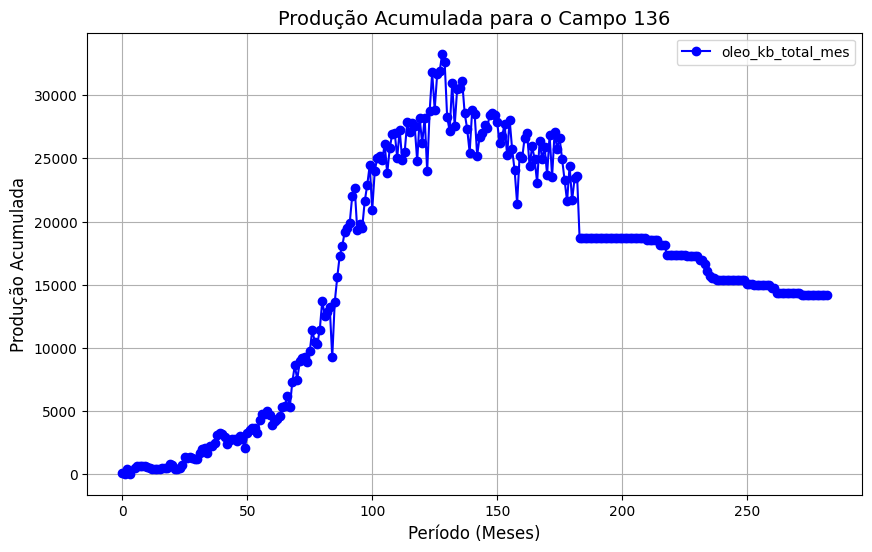

In [ ]:
# Plotar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(df_fields_proj['tempo_total_producao_meses'], df_fields_proj['oleo_kb_total_mes'], marker='o', linestyle='-', color='b', label='oleo_kb_total_mes')
plt.xlabel('Período (Meses)', fontsize=12)
plt.ylabel('Produção Acumulada', fontsize=12)
plt.title(f'Produção Acumulada para o Campo {campo_encoded}', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

##### Hiperparameter tuning

In [ ]:
from lightgbm import LGBMRegressor

model_lgbm = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5
)

model_lgbm.fit(X_train, y_train)
# Previsões no conjunto de teste
y_pred = model_lgbm.predict(X_test)

In [ ]:
from google.colab import files

# Step 2: Save your DataFrame to a CSV file
df_fields_prod.to_csv('df_fields_prod.csv')

# Step 3: Download the file to your local machine
files.download('df_fields_prod.csv')